# <p style="text-align: center;">Remote sensed Image Classification Using CNN</p>

### **1. Import the Required Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

### **2. Load the Image Training and Validation Datasets**

#### **i. Get the Image Dataset Paths**

In [2]:
train_dataset_path = '/kaggle/input/landuse-scene-classification/images_train_test_val/train'
validation_dataset_path = '/kaggle/input/landuse-scene-classification/images_train_test_val/validation'

#### **ii. Load Image Datasets and Apply Augmentations**

Since the images present in the datasets are 150x150px in size, the image height and width are taken as 150, 150 respectively. The batch size value can be changed if required.

In [3]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 32

Loading the training dataset and applying augmentations on it.

In [4]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 7350 images belonging to 21 classes.


Loading the validation dataset.

In [5]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 2100 images belonging to 21 classes.


#### **iii. Get the Label Mappings**

The labels dictionary is made in order to retrive the class names against the label indices used for training the model

In [6]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : agricultural
1 : airplane
2 : baseballdiamond
3 : beach
4 : buildings
5 : chaparral
6 : denseresidential
7 : forest
8 : freeway
9 : golfcourse
10 : harbor
11 : intersection
12 : mediumresidential
13 : mobilehomepark
14 : overpass
15 : parkinglot
16 : river
17 : runway
18 : sparseresidential
19 : storagetanks
20 : tenniscourt


### **3. Plotting Sample Training Images**

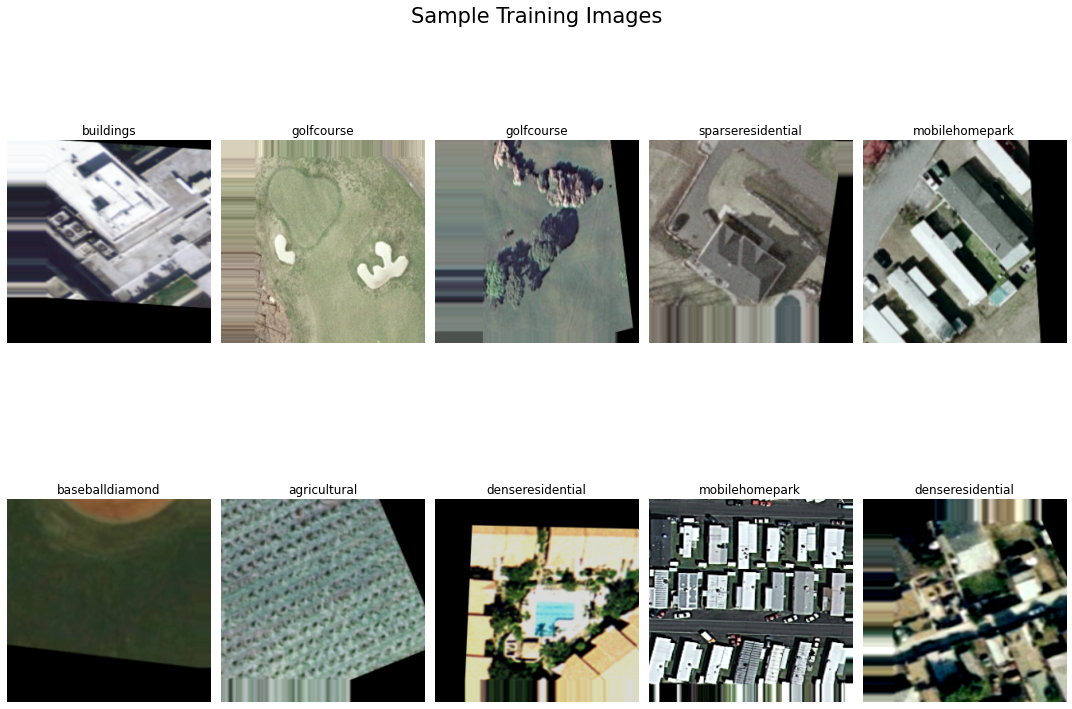

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

### **4. Training a CNN Model**

Since the training dataset is ready let's create a simple CNN Model to train on the image datasets

#### **i. Create a CNN Model**

In [8]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=21, activation='softmax')
    ])
    
    return model

In [9]:
cnn_model = create_model()

In [10]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 128)     9728      
_________________________________________________________________
activation (Activation)      (None, 252, 252, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 128)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 128)     512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      73792     
_________________________________________________________________
activation_1 (Activation)    (None, 124, 124, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0

#### **ii. Defining Callbacks**

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)

#### **a. Reduce Learning Rate on Plateau**

Is used to reduce the learning rate when a metric has stopped improving.

In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

#### **iii. Defining the Optimizer**

In [12]:
optimizer = Adam(learning_rate=0.001)

#### **iv. Compile the Model**

In [13]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

#### **v. Training the Model**

In [14]:
history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/50
230/230 - 186s - loss: 7.0257 - accuracy: 0.1192 - val_loss: 3.7143 - val_accuracy: 0.0652
Epoch 2/50
230/230 - 129s - loss: 3.0757 - accuracy: 0.1332 - val_loss: 3.1011 - val_accuracy: 0.0905
Epoch 3/50
230/230 - 129s - loss: 2.7914 - accuracy: 0.1801 - val_loss: 2.9120 - val_accuracy: 0.1467
Epoch 4/50
230/230 - 129s - loss: 2.6331 - accuracy: 0.2105 - val_loss: 2.5604 - val_accuracy: 0.2371
Epoch 5/50
230/230 - 130s - loss: 2.5333 - accuracy: 0.2316 - val_loss: 2.4777 - val_accuracy: 0.2733
Epoch 6/50
230/230 - 129s - loss: 2.4317 - accuracy: 0.2491 - val_loss: 2.6655 - val_accuracy: 0.2557
Epoch 7/50
230/230 - 128s - loss: 2.3323 - accuracy: 0.2756 - val_loss: 2.2551 - val_accuracy: 0.2752
Epoch 8/50
230/230 - 128s - loss: 2.2569 - accuracy: 0.3031 - val_loss: 2.0218 - val_accuracy: 0.3771
Epoch 9/50
230/230 - 129s - loss: 2.2031 - accuracy: 0.3122 - val_loss: 2.1279 - val_accuracy: 0.3824
Epoch 10/50
230/230 - 128s - loss: 2.1301 - accuracy: 0.3284 - val_loss: 2.3558 - 

### **5. Plotting the Model Metrics**

#### **i. Plotting training and validation accuracy, loss and learning rate**

In [15]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

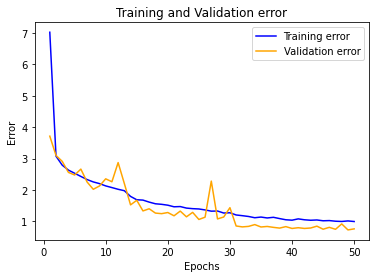

In [17]:
import matplotlib.pyplot as plt
history_dict = history.history
train_acc = history_dict['loss']
val_acc = history_dict['val_loss']
epochs = range(1, len(history_dict['loss'])+1)
plt.plot(epochs, train_acc,'b', label='Training error')
plt.plot(epochs, val_acc,'b', color="orange", label='Validation error')
plt.title('Training and Validation error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

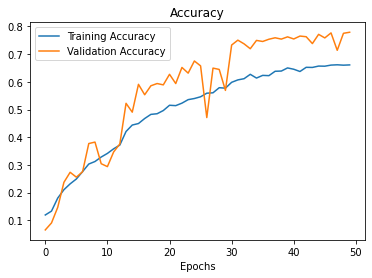

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']  
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(history.history['loss']))
plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

### **6. Testing the Model on Test Set**

Testing the model on the validation dataset because a seperate dataset for testing is not available.

In [19]:
test_dataset = '/kaggle/input/landuse-scene-classification/images_train_test_val/test'

In [20]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 1050 images belonging to 21 classes.


### **7. Model Prediction on the Test Dataset**

In [21]:
predictions = cnn_model.predict(test_generator)

In [23]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

33/33 [==============================] - 5s 142ms/step - loss: 0.7393 - accuracy: 0.7562


In [24]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.739262580871582
Test Accuracy: 0.7561904788017273


The test loss and test accuracy is the same as validation loss and validation accuracy at the last step since the testing and validation datasets are same.

### **8. Plotting the Classification Metrics**

### **i. Confusion Matrix**

In [30]:
cnn_model.evaluate(test_generator)
preds = cnn_model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

33/33 [==============================] - 5s 139ms/step - loss: 0.7393 - accuracy: 0.7562


In [31]:
from sklearn.metrics import confusion_matrix , classification_report 
import seaborn as sns

In [32]:
class_label=list(train_generator.class_indices.keys())

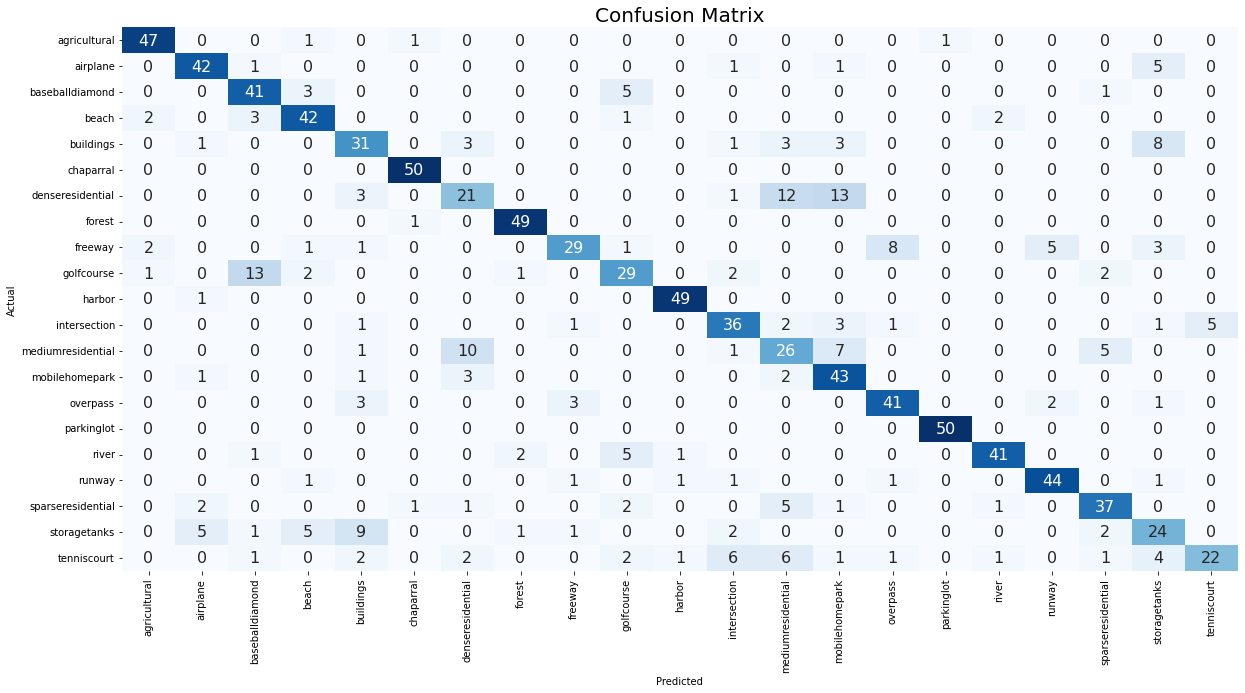

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=class_label, index = class_label)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [26]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

                   precision    recall  f1-score   support

     agricultural       0.90      0.94      0.92        50
         airplane       0.81      0.84      0.82        50
  baseballdiamond       0.67      0.82      0.74        50
            beach       0.76      0.84      0.80        50
        buildings       0.60      0.62      0.61        50
        chaparral       0.94      1.00      0.97        50
 denseresidential       0.53      0.42      0.47        50
           forest       0.92      0.98      0.95        50
          freeway       0.83      0.58      0.68        50
       golfcourse       0.64      0.58      0.61        50
           harbor       0.94      0.98      0.96        50
     intersection       0.71      0.72      0.71        50
mediumresidential       0.46      0.52      0.49        50
   mobilehomepark       0.60      0.86      0.70        50
         overpass       0.79      0.82      0.80        50
       parkinglot       0.98      1.00      0.99       